# Quick Start

MDCraft was developed to be an all-encompassing tool that helps simplify the entire research workflow, from setting up and running molecular dynamics simulations to analyzing, modeling, and plotting data from the trajectories for publication in scientific journals. 

Of special note, MDCraft offers unprecedented flexibility in how data analysis can be carried out. It not only has high-level analysis classes in the `analysis` submodule with carefully thought-out selections of keyword-only arguments to control exactly what is calculated, but also provides direct low-level access to the optimized algorithms used in the analysis classes in the `algorithm` submodule for more seasoned programmers.

The following section will largely focus on the `analysis`, `openmm`, and `plot` submodules since they are the most likely to be used by end users.

## `openmm` submodule

The `openmm` submodule contains helper functions for setting up OpenMM simulations. Notably, it enables coarse-grained simulations with reduced units in a simulation toolkit largely meant for atomistic simulations with real units.

The following code snippet sets up and simulates a simple charged Lennard-Jones fluid without the need for any external topology or force field files.

In [1]:
import sys

from mdcraft.openmm.pair import lj_coul, ljts
from mdcraft.openmm.reporter import NetCDFReporter
from mdcraft.openmm.system import register_particles
from mdcraft.openmm.topology import create_atoms
from mdcraft.openmm.unit import get_lj_scale_factors
import numpy as np
import openmm
from openmm import app, unit

# Define constants and parameters
m = 39.948 * unit.amu
sigma = 3.405 * unit.angstrom
epsilon = 119.8 * unit.kelvin * unit.BOLTZMANN_CONSTANT_kB
N = 10_000
rho_reduced = 0.8
T = 300 * unit.kelvin
varepsilon_r = 78
dt_reduced = 0.0025
every = 100
timesteps = 2_000

# Get scale factors for reduced Lennard-Jones units
scales = get_lj_scale_factors({
    "energy": epsilon,
    "length": sigma,
    "mass": m
})

# Determine system dimensions
dimensions = (N * scales["length"] ** 3 / rho_reduced) ** (1 / 3) * np.ones(3)

# Initialize simulation system and topology
system = openmm.System()
system.setDefaultPeriodicBoxVectors(*(dimensions * np.diag(np.ones(3))))
topology = app.Topology()
topology.setUnitCellDimensions(dimensions)

# Set up excluded volume (Lennard-Jones) and electrostatic (Coulomb) pair potentials
cutoff = 2.5 * scales["length"]
pair_lj_cut = ljts(cutoff, shift=False)
pair_coul = lj_coul(cutoff)
system.addForce(pair_lj_cut)
system.addForce(pair_coul)

# Register particles to pair potentials
for q, name, element in zip(
        (-1, 1),
        ("ANI", "CAT"), 
        (app.Element.getBySymbol(e) for e in ("Cl", "Na"))  # arbitrary
    ):
    register_particles(
        system, 
        topology, 
        N // 2, 
        scales["mass"],
        element=element, 
        name=name, 
        nbforce=pair_coul, 
        charge=q / np.sqrt(varepsilon_r), 
        cnbforces={pair_lj_cut: (scales["length"], scales["molar_energy"])}
    )

# Generate initial particle positions
positions = create_atoms(dimensions, N)

# Set up simulation
dt = dt_reduced * scales["time"]
friction = 1 / scales["time"]
platform = openmm.Platform.getPlatformByName("CPU")
integrator = openmm.LangevinIntegrator(T, friction, dt)
simulation = app.Simulation(topology, system, integrator, platform)
context = simulation.context
context.setPositions(positions)

# Minimize energy
simulation.minimizeEnergy()

# Initialize velocities using Maxwell-Boltzmann distribution
context.setVelocitiesToTemperature(T)

# Write topology file
with open("topology.cif", "w") as f:
    app.PDBxFile.writeFile(
        topology, 
        context.getState(getPositions=True).getPositions(asNumpy=True), 
        f, 
        keepIds=True
    )

# Register topology and state data reporters
simulation.reporters.append(NetCDFReporter("trajectory.nc", every))
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout, 
        reportInterval=every, 
        step=True, 
        temperature=True,
        volume=True, 
        potentialEnergy=True, 
        kineticEnergy=True,
        totalEnergy=True, 
        remainingTime=True, 
        speed=True,
        totalSteps=timesteps
    )
)

# Run simulation
simulation.step(timesteps)

/home/bye/miniconda3/envs/research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#"Step","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Total Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Speed (ns/day)","Time Remaining"
100,-75293.7486847352,26784.039753955032,-48509.708930780165,214.75863591774458,493.47068906249956,0,--
200,-74200.6504754286,29861.887865564284,-44338.762609864316,239.43730530754803,493.47068906249956,19.9,0:42
300,-72972.37502817919,32522.327831608192,-40450.047196570995,260.76913065194077,493.47068906249956,19.7,0:40
400,-72058.00122375895,33674.58419181352,-38383.417031945435,270.00810305559776,493.47068906249956,19.8,0:37
500,-71342.14061384012,34875.46729688478,-36466.67331695534,279.6369723341272,493.47068906249956,19.8,0:35
600,-71171.04509508719,35766.705274308544,-35404.339820778645,286.783058364012,493.47068906249956,19.8,0:32
700,-70342.62957924714,35987.1379445462,-34355.491634700935,288.55052212253463,493.47068906249956,19.8,0:30
800,-70279.18848145117,36517.68519104132,-33761.503290409855,292.8045332423614,493.4

## `analysis` submodule

Now that we have the `topology.cif` and `trajectory.nc` files from the simulation, we can perform data analysis to get structural and dynamic properties that we are interested in, like density profiles, structure factors, and self-diffusion coefficients.

As an illustrative example, the following code snippet first reads the topology and trajectory files using MDAnalysis and then calculates the radial distribution functions for the unique species pairs.

In [2]:
from itertools import combinations_with_replacement

import MDAnalysis as mda
from mdcraft.analysis.structure import RadialDistributionFunction

# Load topology and trajectory
universe = mda.Universe(app.PDBxFile("topology.cif"), "trajectory.nc")

# Select groups containing particles of the same species
groups = [universe.select_atoms(f"name {name}") for name in ("ANI", "CAT")]

# Determine unique species pairs
pairs = list(combinations_with_replacement(range(len(groups)), 2))

# Compute radial distribution functions
rdfs = []
for i, j in pairs:
    rdfs.append(
        RadialDistributionFunction(
            groups[i], 
            groups[j], 
            1_000, 
            (0, 5 * scales["length"].value_in_unit(unit.angstrom)),
            exclusion=(1, 1)
        ).run(start=timesteps // (2 * every))
    )

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


## `plot` submodule

Finally, we can visualize the results from the data analysis in clean, aesthetic, and publication-ready figures using Matplotlib.

The following code snippet plots the radial distribution functions computed in the previous step according to the ACS journal guidelines.

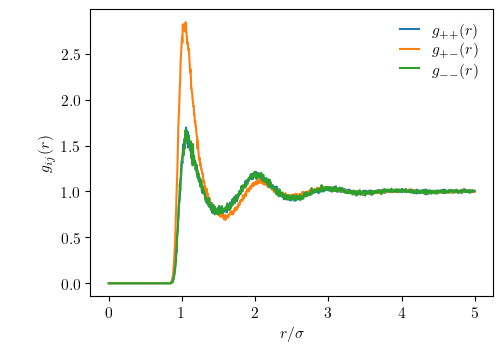

In [3]:
import matplotlib.pyplot as plt
from mdcraft.plot.rcparam import update

# Update Matplotlib rcParams to adhere to the ACS journal guidelines
update("acs", font_scaling=5 / 4, size_scaling=3 / 2)

# Plot and display radial distribution functions
labels = [f"$g_{{{chr(43 + 2 * i)}{chr(43 + 2 * j)}}}(r)$" for i, j in pairs]
_, ax = plt.subplots()
for rdf, label in zip(rdfs, labels):
    ax.plot(
        rdf.results.bins * unit.angstrom / scales["length"], 
        rdf.results.rdf,
        label=label
    )
ax.legend()
ax.set_xlabel("$r/\sigma$")
ax.set_ylabel("$g_{ij}(r)$")
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
plt.show()

In [4]:
import os

os.remove("topology.cif")
os.remove("trajectory.nc")